In [1]:
import os
import random
import math

import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [6, 6]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import draw_box

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/vr1059/self-driving-data/data'
annotation_csv = '/scratch/vr1059/self-driving-data/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 128)
val_labeled_scene_index = np.arange(128, 132)
test_labeled_scene_index = np.arange(132, 134)

In [2]:
def round_up(x):
    return int(math.ceil(x / 50.0)) * 50

def round_down(x):
    return round_up(x) - 50

In [3]:
class_label = 0
class_dict = dict()
reverse_class_dict = []
for i in range(0, 800, 50):
    for j in range(0, 800, 50):
        class_dict[(i, j)] = class_label
        class_label += 1
        reverse_class_dict.append((i, j))

In [4]:
class_dict

{(0, 0): 0,
 (0, 50): 1,
 (0, 100): 2,
 (0, 150): 3,
 (0, 200): 4,
 (0, 250): 5,
 (0, 300): 6,
 (0, 350): 7,
 (0, 400): 8,
 (0, 450): 9,
 (0, 500): 10,
 (0, 550): 11,
 (0, 600): 12,
 (0, 650): 13,
 (0, 700): 14,
 (0, 750): 15,
 (50, 0): 16,
 (50, 50): 17,
 (50, 100): 18,
 (50, 150): 19,
 (50, 200): 20,
 (50, 250): 21,
 (50, 300): 22,
 (50, 350): 23,
 (50, 400): 24,
 (50, 450): 25,
 (50, 500): 26,
 (50, 550): 27,
 (50, 600): 28,
 (50, 650): 29,
 (50, 700): 30,
 (50, 750): 31,
 (100, 0): 32,
 (100, 50): 33,
 (100, 100): 34,
 (100, 150): 35,
 (100, 200): 36,
 (100, 250): 37,
 (100, 300): 38,
 (100, 350): 39,
 (100, 400): 40,
 (100, 450): 41,
 (100, 500): 42,
 (100, 550): 43,
 (100, 600): 44,
 (100, 650): 45,
 (100, 700): 46,
 (100, 750): 47,
 (150, 0): 48,
 (150, 50): 49,
 (150, 100): 50,
 (150, 150): 51,
 (150, 200): 52,
 (150, 250): 53,
 (150, 300): 54,
 (150, 350): 55,
 (150, 400): 56,
 (150, 450): 57,
 (150, 500): 58,
 (150, 550): 59,
 (150, 600): 60,
 (150, 650): 61,
 (150, 700): 62,

In [5]:
reverse_class_dict[7]

(0, 350)

In [6]:
def collate_fn(batch):
    images = []
    target = []
    road_imgs = []
    bbs = []
    target_counts = []
    for x in batch:
        
        # Collect six images for this sample. 
        six_images = []
        for i in range(6):
            six_images.append(torch.as_tensor(x[0][i]))
        
        road_imgs.append(torch.as_tensor(x[2]))
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bins = np.zeros(256)
        counts = np.zeros(90)
        count = 0
        
        for i, corners in enumerate(bb_tens):
            if x[1]['category'][i] not in [1, 3, 6, 8]:
                # Get its four bird's-eye view coordinates. 
                point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
                xs = point_squence.T[0] * 10 + 400
                ys = -point_squence.T[1] * 10 + 400

                # Grab the current bounding box. 
                current_bbs.append((xs, ys))

                # Find the bin/grid cell it falls in, get its class mapping. 
                center_x, center_y = torch.mean(xs).item(), torch.mean(ys).item()
                key = (round_down(center_x), round_down(center_y))
                if key not in class_dict:
                    print(key)
                bin_id = class_dict[key]
                bins[bin_id] = 1
                count += 1
            
        
        counts[count] = 1
        target_counts.append(torch.as_tensor(counts))
        
        images.append(torch.stack(six_images))
                
        target.append(torch.as_tensor(bins))
        
        bbs.append(current_bbs)
                
    boom = torch.stack(images), torch.stack(target), torch.stack(road_imgs), bbs, torch.stack(target_counts)
    return boom

In [7]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
val_transform = transforms.ToTensor()

train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.4, hue = (-0.5, 0.5)),
        transforms.Grayscale(3),
#         transforms.RandomAffine(3),
    ]),
    transforms.ToTensor(),
])


labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=6, num_workers=2, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=6, num_workers=2, shuffle=True, collate_fn=collate_fn)



#### Testing

In [20]:
sample, target, road_img, bbs, counts = iter(train_loader).next()

In [21]:
idx = -1

In [22]:
idx += 1

In [23]:
print(torch.argmax(counts[idx]))

tensor(12)


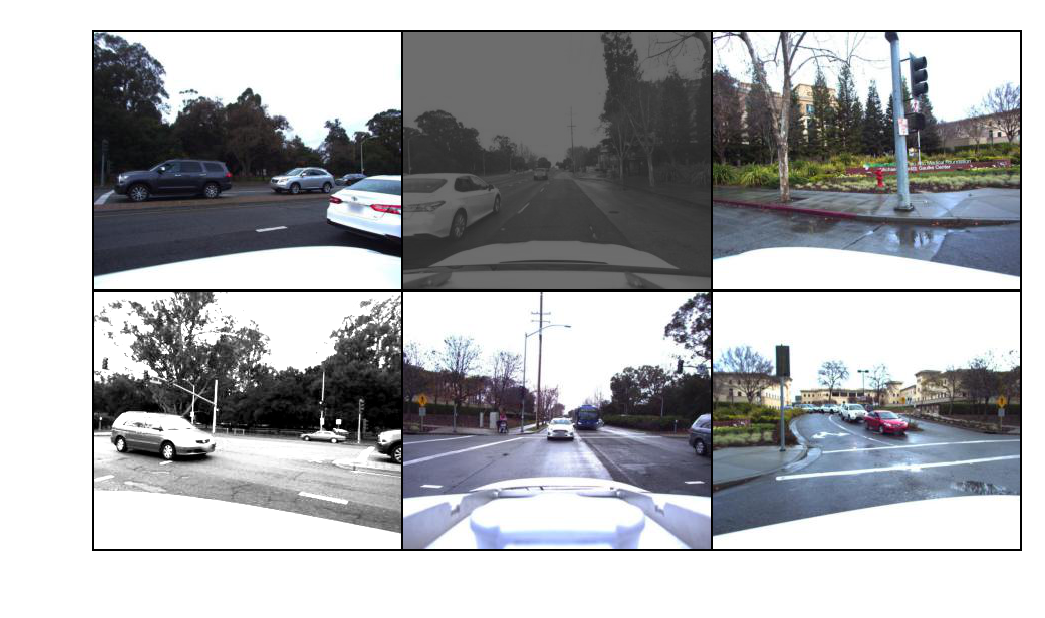

In [24]:
plt.imshow(torchvision.utils.make_grid(sample[idx], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [ ]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")

# `target` is 32 by 81. Find the indices where there's a 1. 
bin_ids = (target[idx] == 1).nonzero()
for bin_id in bin_ids:
    class_box = reverse_class_dict[bin_id]
    
    draw_box(ax, class_box, 'green')
    
def append_first_to_last(tens):
    ret = torch.cat((tens, torch.as_tensor([tens[0]])))
    return ret

    
for bb in bbs[idx]:
    ax.plot(append_first_to_last(bb[0]), append_first_to_last(bb[1]), color='orange')
    


In [ ]:
def draw_box(ax, class_box, color):
    box_xs = [class_box[0], class_box[0], class_box[0]+50, class_box[0]+50, class_box[0]]
    box_ys = [class_box[1], class_box[1]+50, class_box[1]+50, class_box[1], class_box[1]]
    ax.plot(box_xs, box_ys, color=color)

### model

In [8]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet50()
        self.encoder.fc = nn.Identity()
        self.concat_dim = 256 * 6
        
        self.compress = nn.Sequential(OrderedDict([
            ('linear0', nn.Linear(2048, 256)),
            ('drop', nn.Dropout(p = 0.5)),
            ('relu', nn.ReLU())
        ]))
        
        self.classification = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(self.concat_dim, 256)),
        ]))
        
        self.counts = nn.Sequential(OrderedDict([
            ('count1', nn.Linear(self.concat_dim, 90))
        ]))
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.compress(x)
        x = x.view(-1, self.concat_dim)
        return self.classification(x), self.counts(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel()

# for name, param in model.encoder.named_parameters():
#     if("bn" not in name):
#         param.requires_grad = False
        
# unfreeze_layers = [model.encoder.layer3, model.encoder.layer4]
# for layer in unfreeze_layers:
#     for param in layer.parameters():
#         param.requires_grad = True
        
model = model.to(device)
bin_criterion = nn.BCEWithLogitsLoss()
count_criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
best_val_loss = 100

In [10]:
def train():
    model.train()
    labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
    train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=6, num_workers=3, shuffle=True, collate_fn=collate_fn)
    
    train_losses = []
    bin_losses = []
    count_losses = []
    for i, (sample, target, road_img, bbs, target_count) in enumerate(train_loader):

        optimizer.zero_grad()

        sample = sample.to(device)
        target = target.to(device)
        target_count = target_count.to(device)
        
        batch_yhat = []
        batch_ycount = []
        for j, x in enumerate(sample):
            y_hat, y_count = model(x)
            batch_yhat.append(y_hat)
            batch_ycount.append(y_count)
        
        y_hat = torch.stack(batch_yhat).squeeze()
        y_count = torch.stack(batch_ycount).squeeze()
        
        bin_loss = bin_criterion(y_hat, target.float())
        count_loss = count_criterion(y_count, target_count.float())
        loss = 8 * bin_loss + count_loss
        
        train_losses.append(loss.item())
        bin_losses.append(bin_loss.item())
        count_losses.append(count_loss.item())

        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(sample), len(train_loader.dataset),
                50. * i / len(train_loader), loss.item()))
            
    print("\nAverage Train Epoch Loss: ", np.mean(train_losses))
    print("Average Train Bin Epoch Loss: ", np.mean(bin_losses))
    print("Average Train Count Epoch Loss: ", np.mean(count_losses))
            
def val():
    model.eval()
    val_losses = []
    bin_losses = []
    count_losses = []
    for i, (sample, target, road_img, bbs, target_count) in enumerate(val_loader):

        model.eval()

        sample = sample.to(device)
        target = target.to(device)
        target_count = target_count.to(device)

        with torch.no_grad():
            batch_yhat = []
            batch_ycount = []
            for j, x in enumerate(sample):
                y_hat, y_count = model(x)
                batch_yhat.append(y_hat)
                batch_ycount.append(y_count)

            y_hat = torch.stack(batch_yhat).squeeze()
            y_count = torch.stack(batch_ycount).squeeze()
            
            bin_loss = bin_criterion(y_hat, target.float())
            count_loss = count_criterion(y_count, target_count.float())
            loss = 8 * bin_loss + count_loss

            val_losses.append(loss.item())
            bin_losses.append(bin_loss.item())
            count_losses.append(count_loss.item())
            
    print("Average Validation Epoch Loss: ", np.mean(val_losses))
    print("Average Validation Bin Epoch Loss: ", np.mean(bin_losses))
    print("Average Validation Count Epoch Loss: ", np.mean(count_losses))
    print("\n")
    global best_val_loss
    if np.mean(val_losses) < best_val_loss:
        best_val_loss = np.mean(val_losses)
        torch.save(model.state_dict(), 'all_six_images_classify_count.pt')

In [ ]:
epochs = 40
for epoch in range(epochs):
    train()
    val()

Train Epoch: 0 [0/2772 (0%)]	Loss: 6.324596
Train Epoch: 0 [300/2772 (5%)]	Loss: 1.489066
Train Epoch: 0 [600/2772 (11%)]	Loss: 1.915579
Train Epoch: 0 [900/2772 (16%)]	Loss: 1.229141
Train Epoch: 0 [1200/2772 (22%)]	Loss: 1.091381
Train Epoch: 0 [1500/2772 (27%)]	Loss: 1.417295
Train Epoch: 0 [1800/2772 (32%)]	Loss: 1.005971
Train Epoch: 0 [2100/2772 (38%)]	Loss: 1.367725
Train Epoch: 0 [2400/2772 (43%)]	Loss: 2.083943
Train Epoch: 0 [2700/2772 (49%)]	Loss: 1.136899

Average Train Epoch Loss:  1.6244991300426004
Average Train Bin Epoch Loss:  0.1951526537279546
Average Train Count Epoch Loss:  0.06327789979966687
Average Validation Epoch Loss:  2.216824003628322
Average Validation Bin Epoch Loss:  0.2698604879634721
Average Validation Count Epoch Loss:  0.05794010972160669


Train Epoch: 1 [0/2772 (0%)]	Loss: 1.757521
Train Epoch: 1 [300/2772 (5%)]	Loss: 1.222674
Train Epoch: 1 [600/2772 (11%)]	Loss: 1.345488
Train Epoch: 1 [900/2772 (16%)]	Loss: 1.442829
Train Epoch: 1 [1200/2772 (22

Average Validation Epoch Loss:  2.0965046400115606
Average Validation Bin Epoch Loss:  0.2550021278716269
Average Validation Count Epoch Loss:  0.056487618235959894


Train Epoch: 11 [0/2772 (0%)]	Loss: 0.848856
Train Epoch: 11 [300/2772 (5%)]	Loss: 1.096337
Train Epoch: 11 [600/2772 (11%)]	Loss: 1.200596
Train Epoch: 11 [900/2772 (16%)]	Loss: 0.656669
Train Epoch: 11 [1200/2772 (22%)]	Loss: 1.323198
Train Epoch: 11 [1500/2772 (27%)]	Loss: 0.529733
Train Epoch: 11 [1800/2772 (32%)]	Loss: 0.938928
Train Epoch: 11 [2100/2772 (38%)]	Loss: 1.189760
Train Epoch: 11 [2400/2772 (43%)]	Loss: 0.587115
Train Epoch: 11 [2700/2772 (49%)]	Loss: 0.760564

Average Train Epoch Loss:  0.9636831191324052
Average Train Bin Epoch Loss:  0.11609037026150144
Average Train Count Epoch Loss:  0.03496015808661972
Average Validation Epoch Loss:  2.0343810007685708
Average Validation Bin Epoch Loss:  0.24715626044642358
Average Validation Count Epoch Loss:  0.05713090602131117


Train Epoch: 12 [0/2772 (0%)]	Los

Train Epoch: 21 [300/2772 (5%)]	Loss: 0.773723
Train Epoch: 21 [600/2772 (11%)]	Loss: 0.863565
Train Epoch: 21 [900/2772 (16%)]	Loss: 0.547275
Train Epoch: 21 [1200/2772 (22%)]	Loss: 0.549629
Train Epoch: 21 [1500/2772 (27%)]	Loss: 0.712873
Train Epoch: 21 [1800/2772 (32%)]	Loss: 0.800492
Train Epoch: 21 [2100/2772 (38%)]	Loss: 0.679852
Train Epoch: 21 [2400/2772 (43%)]	Loss: 1.076174
Train Epoch: 21 [2700/2772 (49%)]	Loss: 0.781843

Average Train Epoch Loss:  0.7483568005102538
Average Train Bin Epoch Loss:  0.0898335205221718
Average Train Count Epoch Loss:  0.0296886358329486
Average Validation Epoch Loss:  2.065033516713551
Average Validation Bin Epoch Loss:  0.2505111117802915
Average Validation Count Epoch Loss:  0.060944625664324986


Train Epoch: 22 [0/2772 (0%)]	Loss: 0.609466
Train Epoch: 22 [300/2772 (5%)]	Loss: 0.423319
Train Epoch: 22 [600/2772 (11%)]	Loss: 0.516100
Train Epoch: 22 [900/2772 (16%)]	Loss: 0.654201
Train Epoch: 22 [1200/2772 (22%)]	Loss: 0.645219


In [ ]:
# 0.253 val bin loss

# Random Affine 3 degrees
# 0.263 val bin loss


# Need to do 5 * bin_loss + count_loss or something like that. Also more extreme Random Affine maybe?

# Random Affine 5 degrees
# 0.266 val bin loss

# Took out Random Affine. 
# 0.268 val bin loss

# Increased compress dim from 128 to 200. 
# 0.259 val bin loss

# 5 * bin_loss + count_loss
# 0.249 + 0.055

# 8 *
# 0.251 + 0.054

# 8*, RandomAffine(3)
# 0.255

# 8*, RandomAffine(3), weight_decay 0.1

# 10 *, RandomAffine(3)
# 0.259

# 8 *, Normalize (mean, std)
# 0.26

# 8 *, Dropout
# 0.241
